In [61]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
# import yaml
# import re

# import pyarrow as pa
# import pyarrow.parquet as pq

# import gbd_mapping as gm
from vivarium import Artifact

# from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
# from get_draws.api import get_draws

# import vivarium_helpers as vh
# import vivarium_helpers.id_helper as idh
# from vivarium_helpers.vph_output.operations import VPHOperator
# from vivarium_helpers.vph_output import cleaning
from vivarium_helpers.projects.alzheimers import loading
from vivarium_helpers.utils import AttributeMapping, Timer

!date
!whoami
!pwd

Tue Jan 13 23:28:35 PST 2026
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/data_prep


In [48]:
from vivarium_helpers.utils import Timer

# Goal: Estimate the positive predictive value (PPV) of BBBM testing given parameters from Lilly

## Lilly's specifications:

* The sensitivity to 50% 
* The specificity to 97.5% 
* PPV to 90%

Given Lilly's specified sensitivity and specifity and our calibrated
BBBM prevalences (including mixed dementia w/ AD), will we reproduce
their estimated PPV of 90%? Seems doubtful...

## Artifact paths

### Model 10.0

New model with mixed dementia AD added

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0
```

### Model 8.7

Former model, to compare theoretical PPV calculation with our existing
sim/MSLT results

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/
```

# Function to calculate PPV

https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values

$$
\begin{align*}
\text{PPV}
&= \frac{\text{True positives}}{\text{True positives + False positives}}
= \frac{\text{sensitivity}\cdot \text{prevalence}}
    {\text{sensitivity}\cdot \text{prevalence}
    + (1 - \text{specificity})\cdot (1 - \text{prevalence})} 
\end{align*}
$$

The prevalence we're interested in is the prevalence of the BBBM state
among 60-80 year-olds who do not have MCI or dementia.

In [21]:
def ppv(sensitivity, specificity, prevalence):
    return (sensitivity * prevalence
            / (sensitivity * prevalence 
               + (1 - specificity) * (1 - prevalence))
    )

# If prevalence is around 30%, PPV will be around 90% with Lilly's
# specified sensitivity and specificity
lilly_sensitivity = 0.5
lilly_specificity = 0.975
ppv(lilly_sensitivity, lilly_specificity, 0.3)

0.8955223880597014

In [32]:
ppv(lilly_sensitivity, lilly_specificity, 0.01)

0.16806722689075618

In [31]:
ppv(lilly_sensitivity, lilly_specificity, 0.1)

0.6896551724137929

In [39]:
ppv(lilly_sensitivity, lilly_specificity, 0.15)

0.779220779220779

# Define artifact directories

In [ ]:
art_directory = Path('/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts')
art10_directory = art_directory / 'model10.0'
art8_directory = art_directory / 'model8.3'

In [8]:
art8_paths = loading.get_location_artifact_dict(loading.LOCATIONS, 8.3)
art10_paths = loading.get_location_artifact_dict(loading.LOCATIONS, 10.0)
art10_paths

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf',
 'Brazil': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf',
 'China': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf',
 'Germany': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/germany.hdf',
 'Israel': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/israel.hdf',
 'Japan': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/japan.hdf',
 'Spain': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/spain.hdf',
 'Sweden': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/sweden.hdf',
 'Taiwan (Province of China)': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

In [9]:
location = loading.LOCATIONS[0]
location

'United States of America'

In [11]:
art = Artifact(art10_paths[location])
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



# Determine keys needed from artifact

(# Load needed keys for all locations)

The prevalence we're interested in is the prevalence of the BBBM state
among 60-80 year-olds who do not have MCI or dementia, because this is
the population eligible for testing (if we ignore testing history).

Thus, among 60-80
year-olds, we want the prevalence of BBBM among people who are either
susceptible or have BBBM. We can compute this prevalence as:

$$
P(\text{BBBM} \mid \text{S or BBBM})
= \frac{P(\text{BBBM})}{P(\text{S}) + P(\text{BBBM})}
= \frac{P(\text{BBBM} \mid \text{any AD}) P(\text{any AD})}
    {1 - P(\text{any AD})
    + P(\text{BBBM} \mid \text{any AD}) P(\text{any AD})}.
$$

Thus, using Abie's notation, we need $\delta_\text{BBBM} = P(\text{BBBM}
\mid \text{any AD})$, the conditional prevalence of BBBM given any AD
state, and $p = P(\text{any AD})$, the prevalence of any AD state. To
aggregate over age groups, we'll also need the total population.

## Keys needed from artifact:

* $p=$ Prevalence of any AD state: `cause.alzheimers_consistent.prevalence_any`
* $\delta_\text{BBBM} = $ Conditional prevalence of BBBM: `cause.alzheimers_consistent.bbbm_conditional_prevalence`
* $Y = $ Total population: `population.structure`

# Create a class to load artifact data and compute the PPV

In [154]:
class PPVCalculator:
    """Class to load artifact data and calculate the PPV."""

    def __init__(self, artifact_number, locations=None, artifact_data=None):
        """Create a PPVCalculator object with the specified artifact
        version.
        """
        self.artifact_number = artifact_number
        self.locations = locations or loading.LOCATIONS
        self.artifact_paths = loading.get_location_artifact_dict(
            self.locations, self.artifact_number
        )
        self.data = AttributeMapping(artifact_data)

    def load_artifact_keys(self):
        """Load needed keys from artifacts for all locations."""
        with Timer():
            print("Loading all-state prevalence...")
            self.data['prevalence_any'] = loading.load_artifact_data(
                'cause.alzheimers_consistent.prevalence_any',
                location_to_artifact_path=self.artifact_paths
                )
            print("Loading BBBM conditional prevalence...")
            self.data['bbbm_conditional_prevalence'] = loading.load_artifact_data(
                'cause.alzheimers_consistent.bbbm_conditional_prevalence',
                location_to_artifact_path=self.artifact_paths
                )
            print("Loading population structure...")
            self.data['population'] = loading.load_artifact_data(
                'population.structure',
                location_to_artifact_path=self.artifact_paths
                )
            print("Done!")
    
    def calculate_bbbm_prevalence(self):
        """Calculate the unconditional prevalence of BBBM."""
        self.data['bbbm_prevalence'] = (
            self.data.bbbm_conditional_prevalence * self.data.prevalence_any)
        
    def calculate_bbbm_prevalence_among_eligible(self):
        """Calculate the prevalence of BBBM in the test-eligible population."""
        if 'bbbm_prevalence' not in self.data:
            self.calculate_bbbm_prevalence()
        
        self.data['bbbm_prevalence_among_eligible'] = (
            self.data.bbbm_prevalence
            / (1 - self.data.prevalence_any + self.data.bbbm_prevalence)
        )
    
    def ppv(self, sensitivity, specificity):
        """Calculate the PPV for the given sensitivity and specificity,
        using this object's BBBM prevalence among the testing-eligible
        population.
        """
        return ppv(sensitivity, specificity, self.data.bbbm_prevalence_among_eligible)
    
    def average_across_ages(self, df, aggregate_sexes=True, age_query="60 <= age_start < 80"):
        """Compute the population-weighted average of df over a set of age
        groups, optionally aggregating over sexes. df is assumed to
        contain only one year of data, which will be broadcast over
        years in the population dataframe.
        """
        # Filter population and df to specified ages. Drop year from df
        # (assumed to contain only one year of data) to broadcast over
        # year in population dataframe
        pop = self.data.population.query(age_query)
        df = df.query(age_query).droplevel(['year_start', 'year_end'])
        # Specify columns to stratify by depending on whether to
        # aggregate sexes
        optional_sex_stratum = [] if aggregate_sexes else ['sex']
        stratifications = ['location'] + optional_sex_stratum + ['year_start', 'year_end']
        # Compute the population-weighted average
        average = (
            (df * pop).groupby(stratifications).sum()
            / pop.groupby(stratifications).sum()
        )
        return average
    
    def append_average(
            self, measure_name, population_year, aggregate_sexes=True,
            age_start=60, age_end=80):
        """"""
        measure = self.data[measure_name]
        year_start = measure.index.unique('year_start')
        year_end = measure.index.unique('year_end')
        assert len(year_start) == 1 and len(year_end) == 1, 'Non-unique year!'
        year_start, year_end = year_start[0], year_end[0]
        average = (
            self.average_across_ages(
                measure,
                aggregate_sexes,
                # NOTE: Assumes 5-year age bins, e.g., averages have not
                # already been appended
                f"{age_start} <= age_start and age_end <= {age_end}")
            .query(f"year_start=={population_year}")
            .reset_index()
            .assign(sex='Both', age_start=60, age_end=80,
                    year_start=year_start, year_end=year_end)
            .set_index(measure.index.names)
        )
        self.data[measure_name] = pd.concat([measure, average])

    def append_averages(self, population_year, aggregate_sexes=True,
            age_start=60, age_end=80):
        """"""
        for measure_name in ['prevalence_any', 'bbbm_prevalence_among_eligible']:
            self.append_average(measure_name, population_year, 
                                aggregate_sexes, age_start, age_end)

# Create PPVCalculator objects and load artifact keys

In [ ]:
calc10 = PPVCalculator(10.0)
calc8 = PPVCalculator(8.3)

calc10.load_artifact_keys()
calc8.load_artifact_keys()

Loading all-state prevalence...
Loading BBBM conditional prevalence...
Loading population structure...
Done!
Elapsed time: 0:00:22.041951
Loading all-state prevalence...
Loading BBBM conditional prevalence...
Loading population structure...
Done!
Elapsed time: 0:00:23.988204


In [155]:
# Shortcut to avoid reloading data during development
calc10 = PPVCalculator(10.0, artifact_data=calc10.data)
calc8 = PPVCalculator(8.3, artifact_data=calc8.data)

# Calculate prevalence

In [156]:
calc10.calculate_bbbm_prevalence_among_eligible()
calc8.calculate_bbbm_prevalence_among_eligible()

In [166]:
calc10.data.bbbm_prevalence_among_eligible.query("60 <= age_start < 80").T.describe()

location   United States of America                                      \
sex                            Male                                       
age_start                        60          65          70          75   
age_end                          65          70          75          80   
year_start                     2025        2025        2025        2025   
year_end                       2026        2026        2026        2026   
count                    500.000000  500.000000  500.000000  500.000000   
mean                       0.004578    0.010821    0.020550    0.053336   
std                        0.001270    0.003024    0.007105    0.016059   
min                        0.001639    0.003225    0.008354    0.015608   
25%                        0.003692    0.008868    0.015071    0.040796   
50%                        0.004514    0.010948    0.019187    0.054147   
75%                        0.005417    0.013235    0.025261    0.065978   
max                        0.009203    0.019775    0.043834    0.091341   

location                                                        Brazil  \
sex             Female                                            Male   
age_start           60          65          70          75          60   
age_end             65          70          75          80          65   
year_start        2025        2025        2025        2025        2025   
year_end          2026        2026        2026        2026        2026   
count       500.000000  500.000000  500.000000  500.000000  500.000000   
mean          0.007459    0.020036    0.041066    0.120776    0.005583   
std           0.001657    0.002891    0.006809    0.009665    0.001654   
min           0.004588    0.011675    0.028611    0.102479    0.002170   
25%           0.005935    0.018236    0.035966    0.111356    0.004273   
50%           0.007661    0.020089    0.040646    0.120854    0.005491   
75%           0.009027    0.021759    0.045127    0.130245    0.006719   
max           0.010835    0.027893    0.056394    0.136837    0.011041   

location                ...                   China     Germany      Israel  \
sex                     ...        Both        Both        Both        Both   
age_start           65  ...          60          60          60          60   
age_end             70  ...          80          80          80          80   
year_start        2025  ...        2025        2025        2025        2025   
year_end          2026  ...        2026        2026        2026        2026   
count       500.000000  ...  500.000000  500.000000  500.000000  500.000000   
mean          0.013379  ...    0.033171    0.032624    0.034053    0.012445   
std           0.003895  ...    0.001168    0.001568    0.002246    0.001669   
min           0.004889  ...    0.029818    0.028665    0.028466    0.008261   
25%           0.010406  ...    0.032437    0.031491    0.032523    0.011329   
50%           0.013495  ...    0.033233    0.032745    0.034130    0.012407   
75%           0.016380  ...    0.034076    0.033793    0.035510    0.013618   
max           0.023947  ...    0.036031    0.036432    0.041066    0.016233   

location         Japan       Spain      Sweden Taiwan (Province of China)  \
sex               Both        Both        Both                       Both   
age_start           60          60          60                         60   
age_end             80          80          80                         80   
year_start        2025        2025        2025                       2025   
year_end          2026        2026        2026                       2026   
count       500.000000  500.000000  500.000000                 500.000000   
mean          0.023040    0.021915    0.023184                   0.021874   
std           0.003068    0.001266    0.002236                   0.001193   
min           0.014714    0.018524    0.016992                   0.019026   
25%           0.020999    0.021065 

In [158]:
calc8.data.bbbm_prevalence_among_eligible.query("60 <= age_start < 80").T.describe()

location   United States of America                                      \
sex                            Male                                       
age_start                        60          65          70          75   
age_end                          65          70          75          80   
year_start                     2025        2025        2025        2025   
year_end                       2026        2026        2026        2026   
count                    500.000000  500.000000  500.000000  500.000000   
mean                       0.002430    0.005872    0.011883    0.030135   
std                        0.000706    0.001731    0.003923    0.008666   
min                        0.000757    0.002142    0.004808    0.008779   
25%                        0.001901    0.004607    0.008708    0.023724   
50%                        0.002423    0.005896    0.011522    0.030607   
75%                        0.002947    0.007299    0.014952    0.036471   
max                        0.004896    0.010830    0.023886    0.052249   

location                                                        Brazil  \
sex             Female                                            Male   
age_start           60          65          70          75          60   
age_end             65          70          75          80          65   
year_start        2025        2025        2025        2025        2025   
year_end          2026        2026        2026        2026        2026   
count       500.000000  500.000000  500.000000  500.000000  500.000000   
mean          0.004643    0.010778    0.022916    0.053439    0.003032   
std           0.001164    0.002865    0.006404    0.013745    0.000884   
min           0.002116    0.003745    0.012672    0.020354    0.001048   
25%           0.003799    0.009090    0.017737    0.043048    0.002383   
50%           0.004642    0.010798    0.021883    0.053963    0.003042   
75%           0.005285    0.012812    0.026616    0.063589    0.003649   
max           0.009217    0.018344    0.043220    0.086597    0.005917   

location                ... Taiwan (Province of China)              \
sex                     ...                     Female               
age_start           65  ...                         70          75   
age_end             70  ...                         75          80   
year_start        2025  ...                       2025        2025   
year_end          2026  ...                       2026        2026   
count       500.000000  ...                 500.000000  500.000000   
mean          0.007168  ...                   0.017105    0.039862   
std           0.002130  ...                   0.004887    0.010143   
min           0.002747  ...                   0.008498    0.014260   
25%           0.005553  ...                   0.013298    0.032558   
50%           0.007146  ...                   0.016153    0.040191   
75%           0.008700  ...                   0.020639    0.047584   
max           0.012896  ...                   0.032699    0.061884   

location   United Kingdom                                                  \
sex                  Male                                          Female   
age_start              60          65          70          75          60   
age_end                65          70          75          80          65   
year_start           2025        2025        2025        2025        2025   
year_end             2026        2026        2026        2026        2026   
count          500.000000  500.000000  500.000000  500.000000  500.000000   
mean             0.001358    0.004000    0.010889    0.026636    0.002625   
std              0.000434    0.001258    0.003293    0.007434    0.000854   
min              0.000454    0.001235    0.004884    0.007760    0.000847   
25%              0.001022    0.003030    0.008246    0.020976    0.002006   
50%              0.001322    0.004084    0.010450    0.026564    0.002573   
75%    

# Calculate PPV

In [159]:
calc10.data.keys()

dict_keys(['prevalence_any', 'bbbm_conditional_prevalence', 'population', 'bbbm_prevalence', 'bbbm_prevalence_among_eligible'])

In [167]:
ppv10 = calc10.ppv(lilly_sensitivity, lilly_specificity)
ppv10.query("60 <= age_start < 80").T.describe()

location   United States of America                                      \
sex                            Male                                       
age_start                        60          65          70          75   
age_end                          65          70          75          80   
year_start                     2025        2025        2025        2025   
year_end                       2026        2026        2026        2026   
count                    500.000000  500.000000  500.000000  500.000000   
mean                       0.083756    0.177502    0.288729    0.516825   
std                        0.021419    0.042359    0.071123    0.087345   
min                        0.031795    0.060784    0.144195    0.240758   
25%                        0.069001    0.151783    0.234328    0.459641   
50%                        0.083141    0.181260    0.281223    0.533787   
75%                        0.098233    0.211518    0.341372    0.585539   
max                        0.156667    0.287480    0.478314    0.667825   

location                                                        Brazil  \
sex             Female                                            Male   
age_start           60          65          70          75          60   
age_end             65          70          75          80          65   
year_start        2025        2025        2025        2025        2025   
year_end          2026        2026        2026        2026        2026   
count       500.000000  500.000000  500.000000  500.000000  500.000000   
mean          0.129953    0.289020    0.458254    0.732136    0.100187   
std           0.025524    0.030660    0.042816    0.018117    0.026942   
min           0.084398    0.191103    0.370704    0.695457    0.041689   
25%           0.106672    0.270873    0.427316    0.714790    0.079041   
50%           0.133751    0.290792    0.458687    0.733287    0.099446   
75%           0.154114    0.307893    0.485913    0.749685    0.119174   
max           0.179699    0.364622    0.544478    0.760226    0.182528   

location                ...                   China     Germany      Israel  \
sex                     ...        Both        Both        Both        Both   
age_start           65  ...          60          60          60          60   
age_end             70  ...          80          80          80          80   
year_start        2025  ...        2025        2025        2025        2025   
year_end          2026  ...        2026        2026        2026        2026   
count       500.000000  ...  500.000000  500.000000  500.000000  500.000000   
mean          0.210392  ...    0.406827    0.402583    0.413086    0.200737   
std           0.050224  ...    0.008837    0.012009    0.016544    0.021898   
min           0.089471  ...    0.380688    0.371152    0.369483    0.142801   
25%           0.173769  ...    0.401372    0.394046    0.402029    0.186453   
50%           0.214816  ...    0.407410    0.403719    0.414083    0.200809   
75%           0.249844  ...    0.413683    0.411592    0.424081    0.216370   
max           0.329169  ...    0.427774    0.430585    0.461350    0.248133   

location         Japan       Spain      Sweden Taiwan (Province of China)  \
sex               Both        Both        Both                       Both   
age_start           60          60          60                         60   
age_end             80          80          80                         80   
year_start        2025        2025        2025                       2025   
year_end          2026        2026        2026                       2026   
count       500.000000  500.000000  500.000000                 500.000000   
mean          0.319290    0.309235    0.321254                   0.308846   
std           0.030016    0.012664    0.021608                   0.011940   
min           0.229982    0.274034    0.256903                   0.279488   
25%           0.300200    0.300881 

In [151]:
calc8.ppv(0.9, 0.98).query("60 <= age_start < 80").T.describe()

location   United States of America                                      \
sex                            Male                                       
age_start                        60          65          70          75   
age_end                          65          70          75          80   
year_start                     2025        2025        2025        2025   
year_end                       2026        2026        2026        2026   
count                    500.000000  500.000000  500.000000  500.000000   
mean                       0.098071    0.206987    0.342664    0.570273   
std                        0.025947    0.049709    0.075460    0.079549   
min                        0.032988    0.088093    0.178581    0.284969   
25%                        0.078946    0.172378    0.283300    0.522338   
50%                        0.098521    0.210678    0.344065    0.586917   
75%                        0.117401    0.248619    0.405849    0.630082   
max                        0.181271    0.330076    0.524076    0.712712   

location                                                        Brazil  \
sex             Female                                            Male   
age_start           60          65          70          75          60   
age_end             65          70          75          80          65   
year_start        2025        2025        2025        2025        2025   
year_end          2026        2026        2026        2026        2026   
count       500.000000  500.000000  500.000000  500.000000  500.000000   
mean          0.171963    0.323767    0.503963    0.706778    0.119311   
std           0.035741    0.061644    0.068698    0.061447    0.031018   
min           0.087118    0.144671    0.366109    0.483198    0.045066   
25%           0.146466    0.292189    0.448298    0.669345    0.097064   
50%           0.173467    0.329410    0.501689    0.719640    0.120727   
75%           0.192962    0.368692    0.551664    0.753441    0.141494   
max           0.295083    0.456792    0.670269    0.810115    0.211252   

location                ... Taiwan (Province of China)              \
sex                     ...                     Female               
age_start           65  ...                         70          75   
age_end             70  ...                         75          80   
year_start        2025  ...                       2025        2025   
year_end          2026  ...                       2026        2026   
count       500.000000  ...                 500.000000  500.000000   
mean          0.241241  ...                   0.430711    0.640636   
std           0.055960  ...                   0.069843    0.067712   
min           0.110285  ...                   0.278333    0.394305   
25%           0.200825  ...                   0.377514    0.602294   
50%           0.244655  ...                   0.424897    0.653298   
75%           0.283131  ...                   0.486736    0.692145   
max           0.370232  ...                   0.603361    0.748016   

location   United Kingdom                                                  \
sex                  Male                                          Female   
age_start              60          65          70          75          60   
age_end                65          70          75          80          65   
year_start           2025        2025        2025        2025        2025   
year_end             2026        2026        2026        2026        2026   
count          500.000000  500.000000  500.000000  500.000000  500.000000   
mean             0.057361    0.151122    0.324804    0.540401    0.104851   
std              0.017312    0.041370    0.066677    0.077579    0.030733   
min              0.020043    0.052691    0.180920    0.260308    0.036739   
25%              0.043993    0.120321    0.272274    0.490877    0.082937   
50%              0.056216    0.155770    0.322132    0.551166    0.104006   
75%    

# Compute averages

In [160]:
calc10.append_averages(2035)
calc8.append_averages(2035)

In [172]:
calc10.data.bbbm_prevalence_among_eligible.query("sex=='Both'").T.describe()

location,Brazil,China,Germany,Israel,Japan,Spain,Sweden,Taiwan (Province of China),United Kingdom,United States of America
sex,Both,Both,Both,Both,Both,Both,Both,Both,Both,Both
age_start,60,60,60,60,60,60,60,60,60,60
age_end,80,80,80,80,80,80,80,80,80,80
year_start,2025,2025,2025,2025,2025,2025,2025,2025,2025,2025
year_end,2026,2026,2026,2026,2026,2026,2026,2026,2026,2026
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.033171,0.032624,0.034053,0.012445,0.023040,0.021915,0.023184,0.021874,0.029699,0.034075
std,0.001168,0.001568,0.002246,0.001669,0.003068,0.001266,0.002236,0.001193,0.001769,0.001389
min,0.029818,0.028665,0.028466,0.008261,0.014714,0.018524,0.016992,0.019026,0.025473,0.030130
25%,0.032437,0.031491,0.032523,0.011329,0.020999,0.021065,0.021721,0.020905,0.028353,0.033089


In [176]:
ppv(lilly_sensitivity, lilly_specificity, .03)

0.3821656050955412

In [164]:
calc10.ppv(lilly_sensitivity, lilly_specificity).query("age_start==60 and age_end==80").T.describe()

location,Brazil,China,Germany,Israel,Japan,Spain,Sweden,Taiwan (Province of China),United Kingdom,United States of America
sex,Both,Both,Both,Both,Both,Both,Both,Both,Both,Both
age_start,60,60,60,60,60,60,60,60,60,60
age_end,80,80,80,80,80,80,80,80,80,80
year_start,2025,2025,2025,2025,2025,2025,2025,2025,2025,2025
year_end,2026,2026,2026,2026,2026,2026,2026,2026,2026,2026
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.406827,0.402583,0.413086,0.200737,0.319290,0.309235,0.321254,0.308846,0.379405,0.413512
std,0.008837,0.012009,0.016544,0.021898,0.030016,0.012664,0.021608,0.011940,0.014541,0.010248
min,0.380688,0.371152,0.369483,0.142801,0.229982,0.274034,0.256903,0.279488,0.343302,0.383220
25%,0.401372,0.394046,0.402029,0.186453,0.300200,0.300881,0.307513,0.299246,0.368530,0.406325


In [ ]:
# Averaging the PPV across ages is different computing the PPV among all
# ages in range 60-80
calc10.average_across_ages(ppv10).query("year_start==2035").T.describe()

location,Brazil,China,Germany,Israel,Japan,Spain,Sweden,Taiwan (Province of China),United Kingdom,United States of America
year_start,2035.0,2035.0,2035.0,2035.0,2035.0,2035.0,2035.0,2035.0,2035.0,2035.0
year_end,2036.0,2036.0,2036.0,2036.0,2036.0,2036.0,2036.0,2036.0,2036.0,2036.0
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.337252,0.329095,0.347155,0.170362,0.256588,0.249757,0.260614,0.256300,0.280248,0.329734
std,0.006782,0.007394,0.007788,0.011480,0.013301,0.007652,0.009787,0.006627,0.008724,0.007634
min,0.316447,0.306241,0.322648,0.133489,0.209436,0.226868,0.228113,0.236221,0.255593,0.307741
25%,0.333704,0.325001,0.342576,0.163932,0.248475,0.244859,0.254858,0.252371,0.275123,0.324934
50%,0.337848,0.329705,0.347585,0.171636,0.259227,0.250352,0.261770,0.256816,0.281096,0.330250
75%,0.341957,0.334154,0.352269,0.178583,0.265932,0.255444,0.267384,0.261279,0.286132,0.335002
max,0.352789,0.349730,0.365756,0.197095,0.285374,0.266877,0.285064,0.270153,0.301728,0.349094


# Make final PPV table

In [188]:
pairs = [(0.5, 0.975), (0.9, 0.975), (0.5, 0.99), (0.9, 0.99)]
ppvs = []
for pair in pairs:
    ppvs.append(calc10.ppv(*pair).query("age_start==60 and age_end==80").mean(axis=1))

ppv_table = pd.concat(ppvs, keys=pairs, names=['sensitivity', 'specificity'], axis=1)
ppv_table.droplevel(['sex', 'age_start', 'age_end', 'year_start', 'year_end']).round(3)

sensitivity,0.5,0.9,0.5,0.9
specificity,0.975,0.975,0.990,0.990
location,,,,
Brazil,0.407,0.552,0.632,0.755
China,0.403,0.548,0.627,0.752
Germany,0.413,0.559,0.637,0.760
Israel,0.201,0.311,0.385,0.529
Japan,0.319,0.457,0.539,0.677
Spain,0.309,0.446,0.528,0.668
Sweden,0.321,0.460,0.541,0.680
Taiwan (Province of China),0.309,0.446,0.527,0.668


In [179]:
value = calc10.ppv(lilly_sensitivity, lilly_specificity).query("age_start==60 and age_end==80").mean(axis=1)
value

location                    sex   age_start  age_end  year_start  year_end
Brazil                      Both  60         80       2025        2026        0.406827
China                       Both  60         80       2025        2026        0.402583
Germany                     Both  60         80       2025        2026        0.413086
Israel                      Both  60         80       2025        2026        0.200737
Japan                       Both  60         80       2025        2026        0.319290
Spain                       Both  60         80       2025        2026        0.309235
Sweden                      Both  60         80       2025        2026        0.321254
Taiwan (Province of China)  Both  60         80       2025        2026        0.308846
United Kingdom              Both  60         80       2025        2026        0.379405
United States of America    Both  60         80       2025        2026        0.413512
dtype: float64

# Draw some plots

In [235]:
bbbm_prev_by_age = calc10.data.bbbm_prevalence_among_eligible.query(
    "sex != 'Both' and 60 <= age_start < 80"
    " and location == 'United States of America'"
    ).mean(axis=1).rename('prevalence').reset_index()
bbbm_prev_by_age

,location,sex,age_start,age_end,year_start,year_end,prevalence
0,United States of America,Male,60,65,2025,2026,0.004578
1,United States of America,Male,65,70,2025,2026,0.010821
2,United States of America,Male,70,75,2025,2026,0.020550
3,United States of America,Male,75,80,2025,2026,0.053336
4,United States of America,Female,60,65,2025,2026,0.007459
5,United States of America,Female,65,70,2025,2026,0.020036
6,United States of America,Female,70,75,2025,2026,0.041066
7,United States of America,Female,75,80,2025,2026,0.120776


In [240]:
ppv_by_age = ppv10.query(
    "sex != 'Both' and 60 <= age_start < 80"
    " and location == 'United States of America'"
    ).mean(axis=1).rename('ppv').reset_index()

ppv_by_age

,location,sex,age_start,age_end,year_start,year_end,ppv
0,United States of America,Male,60,65,2025,2026,0.083756
1,United States of America,Male,65,70,2025,2026,0.177502
2,United States of America,Male,70,75,2025,2026,0.288729
3,United States of America,Male,75,80,2025,2026,0.516825
4,United States of America,Female,60,65,2025,2026,0.129953
5,United States of America,Female,65,70,2025,2026,0.289020
6,United States of America,Female,70,75,2025,2026,0.458254
7,United States of America,Female,75,80,2025,2026,0.732136


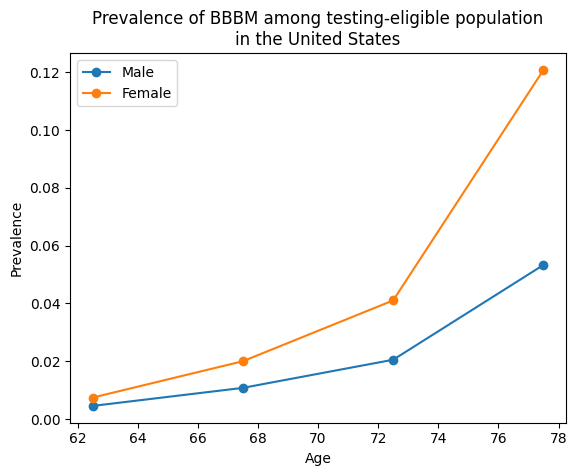

In [237]:
fig, ax = plt.subplots()
for sex in ['Male', 'Female']:
       df = bbbm_prev_by_age.query("sex==@sex")
       ax.plot(df['age_start'] + 2.5, df['prevalence'], marker='o', label=sex)
ax.set(xlabel="Age", ylabel="Prevalence",
       title="Prevalence of BBBM among testing-eligible population\nin the United States")
ax.legend()
plt.show()

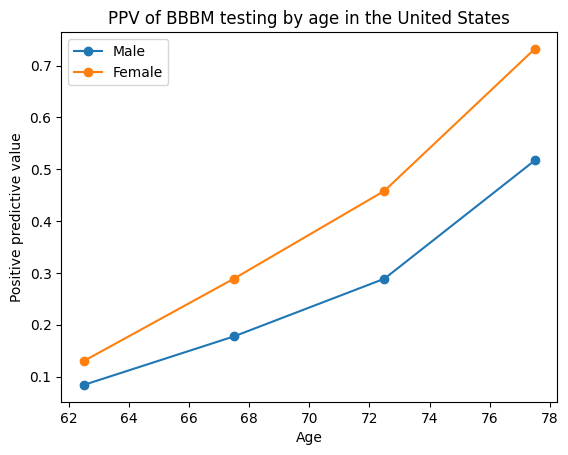

In [244]:
fig, ax = plt.subplots()
for sex in ['Male', 'Female']:
       df = ppv_by_age.query("sex==@sex")
       ax.plot(df['age_start'] + 2.5, df['ppv'], marker='o', label=sex)
ax.set(xlabel="Age", ylabel="Positive predictive value",
       title="PPV of BBBM testing by age in the United States")
ax.legend()
plt.show()

In [14]:
prevalence_any10 = loading.load_artifact_data(
    'cause.alzheimers_consistent.prevalence_any',
    location_to_artifact_path=art10_paths)
prevalence_any10

draw_0  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      8.967526e-10   
                                35        40      2025       2026      1.335133e-07   
                                40        45      2025       2026      6.452669e-07   
                                45        50      2025       2026      1.712386e-03   
                                50        55      2025       2026      2.765897e-03   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      2.339713e-01   
                                85        90      2025       2026      2.842513e-01   
                                90        95      2025       2026      4.152819e-01   
                                95        100     2025       2026      4.152195e-01   
                                100       105     2025       2026      4.223070e-01   

                                                                             draw_1  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      1.302649e-09   
                                35        40      2025       2026      1.752260e-07   
                                40        45      2025       2026      4.966746e-07   
                                45        50      2025       2026      1.704552e-03   
                                50        55      2025       2026      2.828319e-03   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      2.326033e-01   
                                85        90      2025       2026      2.827134e-01   
                                90        95      2025       2026      4.137991e-01   
                                95        100     2025       2026      4.096289e-01   
                                100       105     2025       2026      4.264497e-01   

                                                                             draw_2  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      1.362371e-08   
                                35        40      2025       2026      1.156854e-07   
                                40        45      2025       2026      2.869118e-07   
                                45        50      2025       2026      1.767294e-03   
                                50        55      2025       2026      2.330860e-03   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      2.371126e-01   
                                85        90      2025       2026      2.915603e-01   
                                90        95      2025       2026      4.087080e-01   
                                95        100     2025       2026      4.060841e-01   
                                100       105     2025       2026      4.219096e-01   

                                                                             draw_3  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      6.434898e-08   
                                35        40      2025       2026      1.302276e-07   
                                40        45      2025       2026      2.603070e-07   
                                45        50      2025       2026      1.715377e-03   
                                50        55      2025       2026      2.472284e-03   
...                                                                     

In [15]:
bbbm_conditional_prevalence10 = loading.load_artifact_data(
    'cause.alzheimers_consistent.bbbm_conditional_prevalence',
    location_to_artifact_path=art10_paths
)
bbbm_conditional_prevalence10

draw_0  \
location                 sex    age_start age_end year_start year_end             
United States of America Male   30        35      2025       2026      0.132881   
                                35        40      2025       2026      0.688963   
                                40        45      2025       2026      0.612574   
                                45        50      2025       2026      0.692016   
                                50        55      2025       2026      0.469244   
...                                                                         ...   
United Kingdom           Female 80        85      2025       2026      0.366364   
                                85        90      2025       2026      0.360645   
                                90        95      2025       2026      0.432410   
                                95        100     2025       2026      0.302611   
                                100       105     2025       2026      0.293405   

                                                                         draw_1  \
location                 sex    age_start age_end year_start year_end             
United States of America Male   30        35      2025       2026      0.827176   
                                35        40      2025       2026      0.683696   
                                40        45      2025       2026      0.557526   
                                45        50      2025       2026      0.698378   
                                50        55      2025       2026      0.476049   
...                                                                         ...   
United Kingdom           Female 80        85      2025       2026      0.369790   
                                85        90      2025       2026      0.366288   
                                90        95      2025       2026      0.425676   
                                95        100     2025       2026      0.303164   
                                100       105     2025       2026      0.297963   

                                                                         draw_2  \
location                 sex    age_start age_end year_start year_end             
United States of America Male   30        35      2025       2026      0.503241   
                                35        40      2025       2026      0.633999   
                                40        45      2025       2026      0.528077   
                                45        50      2025       2026      0.687129   
                                50        55      2025       2026      0.419506   
...                                                                         ...   
United Kingdom           Female 80        85      2025       2026      0.369528   
                                85        90      2025       2026      0.352129   
                                90        95      2025       2026      0.415921   
                                95        100     2025       2026      0.310991   
                                100       105     2025       2026      0.295728   

                                                                         draw_3  \
location                 sex    age_start age_end year_start year_end             
United States of America Male   30        35      2025       2026      0.898907   
                                35        40      2025       2026      0.550926   
                                40        45      2025       2026      0.469660   
                                45        50      2025       2026      0.692513   
                                50        55      2025       2026      0.443250   
...                                                                         ...   
United Kingdom           Female 80        85      2025       2026      0.365001   
                                85        90      2025       2026      0.357171   
   

In [16]:
population10 = loading.load_artifact_data(
    'population.structure',
    location_to_artifact_path=art10_paths
)
population10

draw_0  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      9.732314e+06   
                                                  2022       2023      9.641272e+06   
                                                  2023       2024      9.548728e+06   
                                                  2024       2025      9.462539e+06   
                                                  2025       2026      9.394308e+06   
...                                                                             ...   
United Kingdom           Male   95.0      125.0   2046       2047      1.293656e+05   
                                                  2047       2048      1.291769e+05   
                                                  2048       2049      1.282154e+05   
                                                  2049       2050      1.277653e+05   
                                                  2050       2051      1.282134e+05   

                                                                             draw_1  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      1.012986e+07   
                                                  2022       2023      1.003201e+07   
                                                  2023       2024      9.932675e+06   
                                                  2024       2025      9.841851e+06   
                                                  2025       2026      9.768750e+06   
...                                                                             ...   
United Kingdom           Male   95.0      125.0   2046       2047      1.307753e+05   
                                                  2047       2048      1.314274e+05   
                                                  2048       2049      1.317056e+05   
                                                  2049       2050      1.319924e+05   
                                                  2050       2051      1.332201e+05   

                                                                             draw_2  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      9.854349e+06   
                                                  2022       2023      9.764145e+06   
                                                  2023       2024      9.672565e+06   
                                                  2024       2025      9.588970e+06   
                                                  2025       2026      9.524369e+06   
...                                                                             ...   
United Kingdom           Male   95.0      125.0   2046       2047      1.324703e+05   
                                                  2047       2048      1.331351e+05   
                                                  2048       2049      1.329889e+05   
                                                  2049       2050      1.327452e+05   
                                                  2050       2051      1.334211e+05   

                                                                             draw_3  \
location                 sex    age_start age_end year_start year_end                 
United States of America Female 5.0       10.0    2021       2022      9.445721e+06   
                                                  2022       2023      9.357441e+06   
                                                  2023       2024      9.268302e+06   
                                                  2024       2025      9.186573e+06   
                                                  2025       2026      9.122883e+06   
...                                                                     

# Write function to calculate BBBM prevalence among eligible

In [19]:
bbbm_prevalence10 = bbbm_conditional_prevalence10 * prevalence_any10
bbbm_prev_among_eligible10 = bbbm_prevalence10 / (1 - prevalence_any10 + bbbm_prevalence10)
bbbm_prev_among_eligible10

draw_0  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      1.191612e-10   
                                35        40      2025       2026      9.198572e-08   
                                40        45      2025       2026      3.952737e-07   
                                45        50      2025       2026      1.185624e-03   
                                50        55      2025       2026      1.299788e-03   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      1.006387e-01   
                                85        90      2025       2026      1.252824e-01   
                                90        95      2025       2026      2.349527e-01   
                                95        100     2025       2026      1.768647e-01   
                                100       105     2025       2026      1.766064e-01   

                                                                             draw_1  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      1.077520e-09   
                                35        40      2025       2026      1.198014e-07   
                                40        45      2025       2026      2.769093e-07   
                                45        50      2025       2026      1.191034e-03   
                                50        55      2025       2026      1.348415e-03   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      1.007889e-01   
                                85        90      2025       2026      1.261566e-01   
                                90        95      2025       2026      2.310559e-01   
                                95        100     2025       2026      1.737931e-01   
                                100       105     2025       2026      1.813635e-01   

                                                                             draw_2  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      6.856010e-09   
                                35        40      2025       2026      7.334449e-08   
                                40        45      2025       2026      1.515115e-07   
                                45        50      2025       2026      1.215031e-03   
                                50        55      2025       2026      9.791338e-04   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      1.030206e-01   
                                85        90      2025       2026      1.265762e-01   
                                90        95      2025       2026      2.232947e-01   
                                95        100     2025       2026      1.753507e-01   
                                100       105     2025       2026      1.775182e-01   

                                                                             draw_3  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      5.784377e-08   
                                35        40      2025       2026      7.174572e-08   
                                40        45      2025       2026      1.222557e-07   
                                45        50      2025       2026      1.188548e-03   
                                50        55      2025       2026      1.097351e-03   
...                                                                     

In [30]:
bbbm_prev_among_eligible10.query("60 <= age_start < 80").T.describe()

location   United States of America                                      \
sex                            Male                                       
age_start                        60          65          70          75   
age_end                          65          70          75          80   
year_start                     2025        2025        2025        2025   
year_end                       2026        2026        2026        2026   
count                    500.000000  500.000000  500.000000  500.000000   
mean                       0.004578    0.010821    0.020550    0.053336   
std                        0.001270    0.003024    0.007105    0.016059   
min                        0.001639    0.003225    0.008354    0.015608   
25%                        0.003692    0.008868    0.015071    0.040796   
50%                        0.004514    0.010948    0.019187    0.054147   
75%                        0.005417    0.013235    0.025261    0.065978   
max                        0.009203    0.019775    0.043834    0.091341   

location                                                        Brazil  \
sex             Female                                            Male   
age_start           60          65          70          75          60   
age_end             65          70          75          80          65   
year_start        2025        2025        2025        2025        2025   
year_end          2026        2026        2026        2026        2026   
count       500.000000  500.000000  500.000000  500.000000  500.000000   
mean          0.007459    0.020036    0.041066    0.120776    0.005583   
std           0.001657    0.002891    0.006809    0.009665    0.001654   
min           0.004588    0.011675    0.028611    0.102479    0.002170   
25%           0.005935    0.018236    0.035966    0.111356    0.004273   
50%           0.007661    0.020089    0.040646    0.120854    0.005491   
75%           0.009027    0.021759    0.045127    0.130245    0.006719   
max           0.010835    0.027893    0.056394    0.136837    0.011041   

location                ... Taiwan (Province of China)              \
sex                     ...                     Female               
age_start           65  ...                         70          75   
age_end             70  ...                         75          80   
year_start        2025  ...                       2025        2025   
year_end          2026  ...                       2026        2026   
count       500.000000  ...                 500.000000  500.000000   
mean          0.013379  ...                   0.038322    0.071101   
std           0.003895  ...                   0.004570    0.005566   
min           0.004889  ...                   0.030051    0.060685   
25%           0.010406  ...                   0.034450    0.066799   
50%           0.013495  ...                   0.037930    0.070698   
75%           0.016380  ...                   0.042439    0.074906   
max           0.023947  ...                   0.047963    0.087389   

location   United Kingdom                                                  \
sex                  Male                                          Female   
age_start              60          65          70          75          60   
age_end                65          70          75          80          65   
year_start           2025        2025        2025        2025        2025   
year_end             2026        2026        2026        2026        2026   
count          500.000000  500.000000  500.000000  500.000000  500.000000   
mean             0.002553    0.007390    0.019115    0.046109    0.005547   
std              0.000831    0.002246    0.005830    0.013927    0.000828   
min              0.000881    0.002244    0.007979    0.014333    0.003780   
25%              0.001881    0.005699    0.014554    0.034950    0.004891   
50%              0.002547    0.007408    0.018373    0.046351    0.005629   
75%    

# Calculate PPV

In [23]:
ppv10 = ppv(lilly_sensitivity, lilly_specificity, bbbm_prev_among_eligible10)
ppv10

draw_0  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      2.383223e-09   
                                35        40      2025       2026      1.839711e-06   
                                40        45      2025       2026      7.905415e-06   
                                45        50      2025       2026      2.319008e-02   
                                50        55      2025       2026      2.536924e-02   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      6.911677e-01   
                                85        90      2025       2026      7.412358e-01   
                                90        95      2025       2026      8.599866e-01   
                                95        100     2025       2026      8.112261e-01   
                                100       105     2025       2026      8.109541e-01   

                                                                             draw_1  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      2.155039e-08   
                                35        40      2025       2026      2.396023e-06   
                                40        45      2025       2026      5.538157e-06   
                                45        50      2025       2026      2.329355e-02   
                                50        55      2025       2026      2.629464e-02   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      6.915217e-01   
                                85        90      2025       2026      7.427584e-01   
                                90        95      2025       2026      8.573404e-01   
                                95        100     2025       2026      8.079512e-01   
                                100       105     2025       2026      8.158674e-01   

                                                                             draw_2  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      1.371202e-07   
                                35        40      2025       2026      1.466888e-06   
                                40        45      2025       2026      3.030222e-06   
                                45        50      2025       2026      2.375229e-02   
                                50        55      2025       2026      1.922502e-02   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      6.966992e-01   
                                85        90      2025       2026      7.434840e-01   
                                90        95      2025       2026      8.518473e-01   
                                95        100     2025       2026      8.096229e-01   
                                100       105     2025       2026      8.119116e-01   

                                                                         draw_3  \
location                 sex    age_start age_end year_start year_end             
United States of America Male   30        35      2025       2026      0.000001   
                                35        40      2025       2026      0.000001   
                                40        45      2025       2026      0.000002   
                                45        50      2025       2026      0.023246   
                                50        55      2025       2026      0.021499   
...                                                                         ...   
United Kingdom   

In [28]:
ppv10.query("60 <= age_start < 80").T.describe()

location   United States of America                                      \
sex                            Male                                       
age_start                        60          65          70          75   
age_end                          65          70          75          80   
year_start                     2025        2025        2025        2025   
year_end                       2026        2026        2026        2026   
count                    500.000000  500.000000  500.000000  500.000000   
mean                       0.083756    0.177502    0.288729    0.516825   
std                        0.021419    0.042359    0.071123    0.087345   
min                        0.031795    0.060784    0.144195    0.240758   
25%                        0.069001    0.151783    0.234328    0.459641   
50%                        0.083141    0.181260    0.281223    0.533787   
75%                        0.098233    0.211518    0.341372    0.585539   
max                        0.156667    0.287480    0.478314    0.667825   

location                                                        Brazil  \
sex             Female                                            Male   
age_start           60          65          70          75          60   
age_end             65          70          75          80          65   
year_start        2025        2025        2025        2025        2025   
year_end          2026        2026        2026        2026        2026   
count       500.000000  500.000000  500.000000  500.000000  500.000000   
mean          0.129953    0.289020    0.458254    0.732136    0.100187   
std           0.025524    0.030660    0.042816    0.018117    0.026942   
min           0.084398    0.191103    0.370704    0.695457    0.041689   
25%           0.106672    0.270873    0.427316    0.714790    0.079041   
50%           0.133751    0.290792    0.458687    0.733287    0.099446   
75%           0.154114    0.307893    0.485913    0.749685    0.119174   
max           0.179699    0.364622    0.544478    0.760226    0.182528   

location                ... Taiwan (Province of China)              \
sex                     ...                     Female               
age_start           65  ...                         70          75   
age_end             70  ...                         75          80   
year_start        2025  ...                       2025        2025   
year_end          2026  ...                       2026        2026   
count       500.000000  ...                 500.000000  500.000000   
mean          0.210392  ...                   0.441979    0.603986   
std           0.050224  ...                   0.030656    0.019894   
min           0.089471  ...                   0.382581    0.563722   
25%           0.173769  ...                   0.416424    0.588749   
50%           0.214816  ...                   0.440872    0.603414   
75%           0.249844  ...                   0.469889    0.618236   
max           0.329169  ...                   0.501890    0.656962   

location   United Kingdom                                                  \
sex                  Male                                          Female   
age_start              60          65          70          75          60   
age_end                65          70          75          80          65   
year_start           2025        2025        2025        2025        2025   
year_end             2026        2026        2026        2026        2026   
count          500.000000  500.000000  500.000000  500.000000  500.000000   
mean             0.048466    0.128305    0.275446    0.479779    0.100177   
std              0.015090    0.034762    0.061872    0.084710    0.013610   
min              0.017327    0.043048    0.138578    0.225305    0.070531   
25%              0.036329    0.102849    0.228024    0.420057    0.089506   
50%              0.048597    0.129874    0.272373    0.492921    0.101697   
75%    

In [42]:
_28.filter(like='Female').loc['mean'].max()

0.7636819053832297

In [45]:
_28.filter(like='60').loc['mean'].min()

0.032190361044628475

In [46]:
4

4

In [84]:
bbbm_prev_among_eligible10.droplevel(['year_start', 'year_end']).query("60 <= age_start < 80") * population10.query("60 <= age_start < 80")

draw_0  \
location                 sex    age_start age_end year_start year_end                  
Brazil                   Female 60        65      2021       2022       53404.789666   
                                                  2022       2023       54888.194267   
                                                  2023       2024       56421.784204   
                                                  2024       2025       57889.507231   
                                                  2025       2026       59242.587726   
...                                                                              ...   
United States of America Male   75        80      2046       2047      331183.660704   
                                                  2047       2048      326022.353024   
                                                  2048       2049      319794.243003   
                                                  2049       2050      313836.736323   
                                                  2050       2051      309436.263869   

                                                                              draw_1  \
location                 sex    age_start age_end year_start year_end                  
Brazil                   Female 60        65      2021       2022       59077.442621   
                                                  2022       2023       60719.742198   
                                                  2023       2024       62424.040146   
                                                  2024       2025       64059.994881   
                                                  2025       2026       65570.071938   
...                                                                              ...   
United States of America Male   75        80      2046       2047      279955.210974   
                                                  2047       2048      275753.777610   
                                                  2048       2049      270617.156926   
                                                  2049       2050      265674.855664   
                                                  2050       2051      262011.890965   

                                                                              draw_2  \
location                 sex    age_start age_end year_start year_end                  
Brazil                   Female 60        65      2021       2022       53548.216186   
                                                  2022       2023       55038.008795   
                                                  2023       2024       56581.055927   
                                                  2024       2025       58061.040825   
                                                  2025       2026       59428.653135   
...                                                                              ...   
United States of America Male   75        80      2046       2047      393295.284170   
                                                  2047       2048      387369.918083   
                                                  2048       2049      380165.855829   
                                                  2049       2050      373252.732250   
                                                  2050       2051      368150.776648   

                                                                              draw_3  \
location                 sex    age_start age_end year_start year_end                  
Brazil                   Female 60        65      2021       2022       55708.125734   
                                                  2022       2023       57262.045541   
                                                  2023       2024       58880.665340   
                                                  2024       2025       60436.795389   
                                                  2025       2026       61873.696102   
...                        

In [87]:
groupby_cols = ['location', 'year_start', 'year_end', 'sex']
population10.query("60 <= age_start < 80").groupby(groupby_cols).sum()

draw_0  \
location                 year_start year_end sex                    
Brazil                   2021       2022     Female  1.430231e+07   
                                             Male    1.181902e+07   
                         2022       2023     Female  1.479906e+07   
                                             Male    1.219599e+07   
                         2023       2024     Female  1.533782e+07   
...                                                           ...   
United States of America 2048       2049     Male    3.328702e+07   
                         2049       2050     Female  3.780505e+07   
                                             Male    3.350042e+07   
                         2050       2051     Female  3.804232e+07   
                                             Male    3.373969e+07   

                                                           draw_1  \
location                 year_start year_end sex                    
Brazil                   2021       2022     Female  1.591883e+07   
                                             Male    1.315486e+07   
                         2022       2023     Female  1.647160e+07   
                                             Male    1.357473e+07   
                         2023       2024     Female  1.707273e+07   
...                                                           ...   
United States of America 2048       2049     Male    3.487214e+07   
                         2049       2050     Female  3.932236e+07   
                                             Male    3.510085e+07   
                         2050       2051     Female  3.956380e+07   
                                             Male    3.535500e+07   

                                                           draw_2  \
location                 year_start year_end sex                    
Brazil                   2021       2022     Female  1.405647e+07   
                                             Male    1.161587e+07   
                         2022       2023     Female  1.454618e+07   
                                             Male    1.198811e+07   
                         2023       2024     Female  1.507875e+07   
...                                                           ...   
United States of America 2048       2049     Male    3.388070e+07   
                         2049       2050     Female  3.848417e+07   
                                             Male    3.410960e+07   
                         2050       2051     Female  3.872983e+07   
                                             Male    3.436406e+07   

                                                           draw_3  \
location                 year_start year_end sex                    
Brazil                   2021       2022     Female  1.457877e+07   
                                             Male    1.204747e+07   
                         2022       2023     Female  1.508792e+07   
                                             Male    1.243681e+07   
                         2023       2024     Female  1.564442e+07   
...                                                           ...   
United States of America 2048       2049     Male    3.250504e+07   
                         2049       2050     Female  3.684179e+07   
                                             Male    3.273047e+07   
                         2050       2051     Female  3.707662e+07   
                                             Male    3.298047e+07   

                                                           draw_4  \
location                 year_start year_end sex                    
Brazil                   2021       2022     Female  1.494002e+07   
                                             Male    1.234600e+07   
                         2022       2023     Female  1.546109e+07   
                                             Male    1.274588e+07   
                         2023       2024     Female  

In [ ]:
def average(df, population, aggregate_sexes=True, age_query="60 <= age_start < 80"):
        """Compute the population-weighted average over a set of age
        groups, optionally aggregating over sexes.
        """
        # Filter population and df to specified ages
        pop = population.query(age_query)
        df = df.query(age_query).droplevel(['year_start', 'year_end'])
        # Specify columns to stratify by depending on whether to
        # aggregate sexes
        optional_sex_stratum = [] if aggregate_sexes else ['sex']
        stratifications = ['location'] + optional_sex_stratum + ['year_start', 'year_end']
        # Compute the population-weighted average
        average = (
            (df * pop).groupby(stratifications).sum()
            / pop.groupby(stratifications).sum()
        )
        return average

average(bbbm_prev_among_eligible10, population10, False)

draw_0    draw_1  \
location                 sex    year_start year_end                       
Brazil                   Female 2021       2022      0.036148  0.036330   
                                2022       2023      0.036315  0.036497   
                                2023       2024      0.036541  0.036723   
                                2024       2025      0.036797  0.036979   
                                2025       2026      0.037069  0.037252   
...                                                       ...       ...   
United States of America Male   2046       2047      0.017960  0.015913   
                                2047       2048      0.017793  0.015783   
                                2048       2049      0.017603  0.015642   
                                2049       2050      0.017423  0.015510   
                                2050       2051      0.017279  0.015406   

                                                       draw_2    draw_3  \
location                 sex    year_start year_end                       
Brazil                   Female 2021       2022      0.036621  0.036932   
                                2022       2023      0.036791  0.037104   
                                2023       2024      0.037022  0.037340   
                                2024       2025      0.037285  0.037608   
                                2025       2026      0.037564  0.037895   
...                                                       ...       ...   
United States of America Male   2046       2047      0.020927  0.019337   
                                2047       2048      0.020732  0.019165   
                                2048       2049      0.020512  0.018969   
                                2049       2050      0.020302  0.018782   
                                2050       2051      0.020135  0.018634   

                                                       draw_4    draw_5  \
location                 sex    year_start year_end                       
Brazil                   Female 2021       2022      0.036629  0.037170   
                                2022       2023      0.036800  0.037345   
                                2023       2024      0.037033  0.037584   
                                2024       2025      0.037295  0.037858   
                                2025       2026      0.037572  0.038149   
...                                                       ...       ...   
United States of America Male   2046       2047      0.020932  0.022595   
                                2047       2048      0.020718  0.022390   
                                2048       2049      0.020463  0.022160   
                                2049       2050      0.020213  0.021944   
                                2050       2051      0.020012  0.021775   

                                                       draw_6    draw_7  \
location                 sex    year_start year_end                       
Brazil                   Female 2021       2022      0.037662  0.037527   
                                2022       2023      0.037840  0.037707   
                                2023       2024      0.038084  0.037954   
                                2024       2025      0.038360  0.038236   
                                2025       2026      0.038652  0.038537   
...                                                       ...       ...   
United States of America Male   2046       2047      0.023802  0.023457   
                                2047       2048      0.023506  0.023174   
                                2048       2049      0.023145  0.022833   
                                2049       2050      0.022787  0.022497   
                                2050       2051      0.022496  0.022224   

                                                       draw_8    draw_9  ...  \
location                 sex    year_start year_end                    

In [94]:
_89.query("location=='Brazil' and year_start==2030")

draw_0    draw_1    draw_2    draw_3  \
location sex    year_start year_end                                           
Brazil   Female 2030       2031      0.038635  0.038837  0.039166  0.039538   
         Male   2030       2031      0.018968  0.017565  0.021972  0.020969   

                                       draw_4    draw_5    draw_6    draw_7  \
location sex    year_start year_end                                           
Brazil   Female 2030       2031      0.039124  0.039829  0.040308  0.040265   
         Male   2030       2031      0.021372  0.023524  0.022553  0.022720   

                                       draw_8    draw_9  ...  draw_490  \
location sex    year_start year_end                      ...             
Brazil   Female 2030       2031      0.040799  0.040725  ...  0.038965   
         Male   2030       2031      0.022700  0.021326  ...  0.023536   

                                     draw_491  draw_492  draw_493  draw_494  \
location sex    year_start year_end                                           
Brazil   Female 2030       2031      0.038800  0.039097  0.038661  0.039035   
         Male   2030       2031      0.019528  0.022307  0.020189  0.021299   

                                     draw_495  draw_496  draw_497  draw_498  \
location sex    year_start year_end                                           
Brazil   Female 2030       2031      0.039017  0.039247  0.039083  0.039065   
         Male   2030       2031      0.021946  0.023088  0.023237  0.022194   

                                     draw_499  
location sex    year_start year_end            
Brazil   Female 2030       2031      0.039398  
         Male   2030       2031      0.022869  

[2 rows x 500 columns]

In [97]:
_89.query("location=='Brazil' and year_start==2025")

draw_0    draw_1    draw_2    draw_3  \
location sex    year_start year_end                                           
Brazil   Female 2025       2026      0.037069  0.037252  0.037564  0.037895   
         Male   2025       2026      0.018354  0.017015  0.021229  0.020267   

                                       draw_4    draw_5    draw_6    draw_7  \
location sex    year_start year_end                                           
Brazil   Female 2025       2026      0.037572  0.038149  0.038652  0.038537   
         Male   2025       2026      0.020636  0.022662  0.021737  0.021849   

                                       draw_8    draw_9  ...  draw_490  \
location sex    year_start year_end                      ...             
Brazil   Female 2025       2026      0.039074  0.039009  ...  0.037347   
         Male   2025       2026      0.021905  0.020596  ...  0.022677   

                                     draw_491  draw_492  draw_493  draw_494  \
location sex    year_start year_end                                           
Brazil   Female 2025       2026      0.037193  0.037527  0.037101  0.037478   
         Male   2025       2026      0.018939  0.021649  0.019584  0.020639   

                                     draw_495  draw_496  draw_497  draw_498  \
location sex    year_start year_end                                           
Brazil   Female 2025       2026      0.037460  0.037686  0.037533  0.037553   
         Male   2025       2026      0.021252  0.022371  0.022532  0.021473   

                                     draw_499  
location sex    year_start year_end            
Brazil   Female 2025       2026      0.037863  
         Male   2025       2026      0.022103  

[2 rows x 500 columns]

In [107]:
average(ppv10, population10, True).query("year_start==2035").T.describe()

location,Brazil,China,Germany,Israel,Japan,Spain,Sweden,Taiwan (Province of China),United Kingdom,United States of America
year_start,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035
year_end,2036,2036,2036,2036,2036,2036,2036,2036,2036,2036
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.337252,0.329095,0.347155,0.170362,0.256588,0.249757,0.260614,0.256300,0.280248,0.329734
std,0.006782,0.007394,0.007788,0.011480,0.013301,0.007652,0.009787,0.006627,0.008724,0.007634
min,0.316447,0.306241,0.322648,0.133489,0.209436,0.226868,0.228113,0.236221,0.255593,0.307741
25%,0.333704,0.325001,0.342576,0.163932,0.248475,0.244859,0.254858,0.252371,0.275123,0.324934
50%,0.337848,0.329705,0.347585,0.171636,0.259227,0.250352,0.261770,0.256816,0.281096,0.330250
75%,0.341957,0.334154,0.352269,0.178583,0.265932,0.255444,0.267384,0.261279,0.286132,0.335002
max,0.352789,0.349730,0.365756,0.197095,0.285374,0.266877,0.285064,0.270153,0.301728,0.349094


In [109]:
average_prevalence10 = average(bbbm_prev_among_eligible10, population10, True)
average_prevalence10.query("year_start==2035")

,,,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_490,draw_491,draw_492,draw_493,draw_494,draw_495,draw_496,draw_497,draw_498,draw_499
location,year_start,year_end,,,,,,,,,,,,,,,,,,,,,
Brazil,2035,2036,0.030859,0.030339,0.032601,0.032324,0.032207,0.033723,0.033566,0.033681,0.033939,0.033222,...,0.033354,0.031205,0.032739,0.031436,0.032263,0.032525,0.033228,0.033190,0.032661,0.033175
China,2035,2036,0.031128,0.030713,0.032893,0.032485,0.032333,0.034292,0.034140,0.034707,0.034691,0.033920,...,0.032622,0.031770,0.032327,0.031209,0.031750,0.032049,0.032696,0.032893,0.032500,0.031932
Germany,2035,2036,0.036656,0.035665,0.038364,0.036609,0.038363,0.039658,0.038617,0.040803,0.041066,0.038648,...,0.034968,0.034568,0.035870,0.033592,0.035048,0.035956,0.035436,0.036080,0.035902,0.033802
Israel,2035,2036,0.013324,0.012051,0.013561,0.013026,0.012991,0.014225,0.015544,0.015287,0.014750,0.013692,...,0.014181,0.010812,0.012164,0.011027,0.011690,0.012178,0.012747,0.013419,0.013093,0.012247
Japan,2035,2036,0.020634,0.017170,0.024844,0.021245,0.023546,0.025246,0.027815,0.026844,0.026600,0.024791,...,0.026013,0.019603,0.024186,0.022935,0.022793,0.024385,0.024773,0.024693,0.024495,0.022897
Spain,2035,2036,0.021707,0.020888,0.022862,0.022374,0.022773,0.023979,0.024675,0.024491,0.024331,0.023590,...,0.022393,0.020508,0.021485,0.020613,0.021066,0.021381,0.021789,0.021884,0.021366,0.021519
Sweden,2035,2036,0.025227,0.024021,0.026199,0.025479,0.025916,0.027291,0.029239,0.029777,0.028835,0.027582,...,0.025673,0.022570,0.023479,0.022036,0.022795,0.023284,0.023962,0.024192,0.024049,0.023679
Taiwan (Province of China),2035,2036,0.021996,0.021557,0.022650,0.022196,0.022422,0.023014,0.023352,0.023662,0.023754,0.023465,...,0.021296,0.020153,0.020875,0.020181,0.020993,0.020767,0.021142,0.021206,0.021079,0.020885
United Kingdom,2035,2036,0.027376,0.026738,0.028966,0.028516,0.029174,0.030546,0.031211,0.031448,0.031180,0.030220,...,0.028350,0.026795,0.027727,0.026491,0.027581,0.027881,0.028358,0.028173,0.027603,0.027656


In [110]:
bbbm_prev_among_eligible10

draw_0  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      1.191612e-10   
                                35        40      2025       2026      9.198572e-08   
                                40        45      2025       2026      3.952737e-07   
                                45        50      2025       2026      1.185624e-03   
                                50        55      2025       2026      1.299788e-03   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      1.006387e-01   
                                85        90      2025       2026      1.252824e-01   
                                90        95      2025       2026      2.349527e-01   
                                95        100     2025       2026      1.768647e-01   
                                100       105     2025       2026      1.766064e-01   

                                                                             draw_1  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      1.077520e-09   
                                35        40      2025       2026      1.198014e-07   
                                40        45      2025       2026      2.769093e-07   
                                45        50      2025       2026      1.191034e-03   
                                50        55      2025       2026      1.348415e-03   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      1.007889e-01   
                                85        90      2025       2026      1.261566e-01   
                                90        95      2025       2026      2.310559e-01   
                                95        100     2025       2026      1.737931e-01   
                                100       105     2025       2026      1.813635e-01   

                                                                             draw_2  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      6.856010e-09   
                                35        40      2025       2026      7.334449e-08   
                                40        45      2025       2026      1.515115e-07   
                                45        50      2025       2026      1.215031e-03   
                                50        55      2025       2026      9.791338e-04   
...                                                                             ...   
United Kingdom           Female 80        85      2025       2026      1.030206e-01   
                                85        90      2025       2026      1.265762e-01   
                                90        95      2025       2026      2.232947e-01   
                                95        100     2025       2026      1.753507e-01   
                                100       105     2025       2026      1.775182e-01   

                                                                             draw_3  \
location                 sex    age_start age_end year_start year_end                 
United States of America Male   30        35      2025       2026      5.784377e-08   
                                35        40      2025       2026      7.174572e-08   
                                40        45      2025       2026      1.222557e-07   
                                45        50      2025       2026      1.188548e-03   
                                50        55      2025       2026      1.097351e-03   
...                                                                     

In [128]:
avg = (
    average_prevalence10
    .query("year_start==2035")
    .rename({2035: 2025}, level='year_start')
    .rename({2036: 2026}, level='year_end')
    .assign(sex='Both', age_start=60, age_end=80)
    .set_index(['sex', 'age_start', 'age_end'], append=True)
    .reorder_levels(bbbm_prev_among_eligible10.index.names)
)
avg
pd.concat([bbbm_prev_among_eligible10, avg], )

draw_0  \
location                   sex  age_start age_end year_start year_end                 
United States of America   Male 30        35      2025       2026      1.191612e-10   
                                35        40      2025       2026      9.198572e-08   
                                40        45      2025       2026      3.952737e-07   
                                45        50      2025       2026      1.185624e-03   
                                50        55      2025       2026      1.299788e-03   
...                                                                             ...   
Spain                      Both 60        80      2025       2026      2.170707e-02   
Sweden                     Both 60        80      2025       2026      2.522704e-02   
Taiwan (Province of China) Both 60        80      2025       2026      2.199599e-02   
United Kingdom             Both 60        80      2025       2026      2.737600e-02   
United States of America   Both 60        80      2025       2026      3.164108e-02   

                                                                             draw_1  \
location                   sex  age_start age_end year_start year_end                 
United States of America   Male 30        35      2025       2026      1.077520e-09   
                                35        40      2025       2026      1.198014e-07   
                                40        45      2025       2026      2.769093e-07   
                                45        50      2025       2026      1.191034e-03   
                                50        55      2025       2026      1.348415e-03   
...                                                                             ...   
Spain                      Both 60        80      2025       2026      2.088822e-02   
Sweden                     Both 60        80      2025       2026      2.402078e-02   
Taiwan (Province of China) Both 60        80      2025       2026      2.155692e-02   
United Kingdom             Both 60        80      2025       2026      2.673791e-02   
United States of America   Both 60        80      2025       2026      3.051944e-02   

                                                                             draw_2  \
location                   sex  age_start age_end year_start year_end                 
United States of America   Male 30        35      2025       2026      6.856010e-09   
                                35        40      2025       2026      7.334449e-08   
                                40        45      2025       2026      1.515115e-07   
                                45        50      2025       2026      1.215031e-03   
                                50        55      2025       2026      9.791338e-04   
...                                                                             ...   
Spain                      Both 60        80      2025       2026      2.286183e-02   
Sweden                     Both 60        80      2025       2026      2.619851e-02   
Taiwan (Province of China) Both 60        80      2025       2026      2.265023e-02   
United Kingdom             Both 60        80      2025       2026      2.896634e-02   
United States of America   Both 60        80      2025       2026      3.318123e-02   

                                                                             draw_3  \
location                   sex  age_start age_end year_start year_end                 
United States of America   Male 30        35      2025       2026      5.784377e-08   
                                35        40      2025       2026      7.174572e-08   
                                40        45      2025       2026      1.222557e-07   
                                45        50      2025       2026      1.188548e-03   
                                50        55      2025       2026      1.097351e-03   
...                                                                     